# SNAP Simulations to investigate asymmetries in temporal generalization of decoders

Simulate poisson firing rates that ramp up/down and perform a temporal generalization analysis to confirm that the asymmetry we observe in spiking network simulations and real MFC data is due to ramping dynamics.

In [1]:
import numpy as np

from scipy.optimize import minimize
from scipy.io import loadmat,savemat
from scipy.linalg import fractional_matrix_power
from scipy import interpolate, signal,stats
from scipy.stats import ranksums, sem, ttest_ind
from scipy.ndimage.filters import uniform_filter1d
from scipy.ndimage import gaussian_filter1d, uniform_filter1d

from os import listdir

from sklearn.linear_model import LogisticRegression, LinearRegression, ElasticNet, Ridge
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.metrics import r2_score, roc_auc_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.svm import SVC

import random

import pandas as pd


import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits import mplot3d
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d.art3d import Line3DCollection
from matplotlib.collections import LineCollection

from plotnine import *


import seaborn as sns

# One kind of ramping, classify versus baseline

In [39]:
nNeurons = 20
nTrials = 50
time_frs = np.arange(-3,0.001,0.05)
time = np.arange(-3,0.001,0.001)

spks = np.zeros((nTrials,nNeurons,time.shape[0]))

In [40]:
frs_start = np.zeros(nNeurons,)
frs_end = np.zeros(nNeurons,)

frs_start[0:(frs_start.shape[0]//2)] = 5 #+ np.random.randn(nNeurons//2) # Starting FRs for each increasing neuron
frs_start[(frs_start.shape[0]//2):] = 8 #+ np.random.randn(nNeurons//2) # Starting FRs for each decreasing neuron

frs_end[0:(frs_start.shape[0]//2)] = 8 #+ np.random.randn(nNeurons//2) # Ending FRs for each increasing neuron
frs_end[(frs_start.shape[0]//2):] = 5 #+ np.random.randn(nNeurons//2) # Ending FRs for each decreasing neuron

In [41]:
for ii in range(nNeurons):
    
    this_frs = np.linspace(frs_start[ii],frs_end[ii],time_frs.shape[0])
    
    for kk in range(time_frs.shape[0]-1):
        
        x,y = spks[:,ii,(kk)*50:(kk+1)*50].shape
        spks[:,ii,(kk)*50:(kk+1)*50] = np.random.rand(nTrials,50) < this_frs[kk]/1000

In [46]:
baseline_ix = np.where(np.logical_and(time > -3,time < -2.6))[0]
baseline_frs = spks[:,:,baseline_ix].sum(axis=2)

df_base = pd.DataFrame(baseline_frs)
df_base['label'] = np.zeros(len(df_base,))

accs = []
# sems = []
traintime = []
testtime = []

for tt_train in time[time > -2.5][::50]:
    for tt_test in time[time > -2.5][::50]:
        
    
        train_ix = np.where(np.logical_and(time > tt_train-0.4,time < tt_train))[0]
        train_frs = spks[:,:,train_ix].sum(axis=2)

        df_train = pd.DataFrame(train_frs)
        df_train['label'] = np.ones(len(df_train,))

        tmp = pd.concat([df_base,df_train]).dropna()
        X_train = tmp.drop('label',axis=1).to_numpy()
        y_train = tmp['label'].to_numpy().flatten()

        test_ix = np.where(np.logical_and(time > tt_test - 0.4,time < tt_test))[0]
        test_frs = spks[:,:,test_ix].sum(axis=2)

        df_test = pd.DataFrame(test_frs)
        df_test['label'] = np.ones(len(df_test,))

        tmp = pd.concat([df_base,df_test]).dropna()
        X_test = tmp.drop('label',axis=1).to_numpy()
        y_test = tmp['label'].to_numpy().flatten()

        clf = LDA()
#             clf = SVC()

        clf.fit(X_train,y_train)

#         accs_this = clf.score(X_test,y_test)
        accs_this = roc_auc_score(y_test,clf.predict_proba(X_test)[:,1])

        

        accs.append(accs_this)
        traintime.append(tt_train)
        testtime.append(tt_test)
        
        if tt_train == tt_test:
            print(tt_train,accs_this)
        
        
        
df_tempgen = pd.DataFrame({'accs':accs,'traintime':traintime,'testtime':testtime})

-2.499000000000055 0.6032
-2.4490000000000607 0.6315999999999999
-2.399000000000066 0.68
-2.3490000000000717 0.714
-2.299000000000077 0.7336
-2.2490000000000827 0.742
-2.199000000000088 0.7512
-2.1490000000000937 0.7724
-2.0990000000000992 0.7456
-2.0490000000001047 0.7891999999999999
-1.9990000000001102 0.8168
-1.9490000000001158 0.8248
-1.8990000000001213 0.8335999999999999
-1.8490000000001268 0.8468
-1.7990000000001323 0.856
-1.7490000000001378 0.858
-1.6990000000001433 0.8704
-1.6490000000001488 0.8428
-1.5990000000001543 0.846
-1.5490000000001598 0.8335999999999999
-1.4990000000001653 0.8364
-1.4490000000001708 0.8592000000000001
-1.3990000000001763 0.8704000000000001
-1.3490000000001818 0.8908
-1.2990000000001873 0.8968
-1.2490000000001928 0.9124
-1.1990000000001984 0.912
-1.1490000000002039 0.9136
-1.0990000000002094 0.9204
-1.0490000000002149 0.9232
-0.9990000000002204 0.9304
-0.9490000000002259 0.9079999999999999
-0.8990000000002314 0.9024
-0.8490000000002369 0.9336
-0.7990000

In [47]:
print("T-Test output: ",ttest_ind(df_tempgen.loc[df_tempgen.traintime.values > df_tempgen.testtime.values,'accs'],
               df_tempgen.loc[df_tempgen.traintime.values < df_tempgen.testtime.values,'accs']))
print("Rank-Sum output: ",ranksums(df_tempgen.loc[df_tempgen.traintime.values > df_tempgen.testtime.values,'accs'],
               df_tempgen.loc[df_tempgen.traintime.values < df_tempgen.testtime.values,'accs']))

T-Test output:  Ttest_indResult(statistic=-22.04182837059073, pvalue=2.2890708380771712e-98)
Rank-Sum output:  RanksumsResult(statistic=-20.016544877506025, pvalue=3.9519449410060076e-89)


/Users/gavenas/opt/anaconda3/envs/pymer4/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 4 x 4 in image.
/Users/gavenas/opt/anaconda3/envs/pymer4/lib/python3.9/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: figures/decoding/simulated_auc_2D_20neurons.svg
/Users/gavenas/opt/anaconda3/envs/pymer4/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 4 x 4 in image.
/Users/gavenas/opt/anaconda3/envs/pymer4/lib/python3.9/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: figures/decoding/simulated_auc_2D_20neurons.png


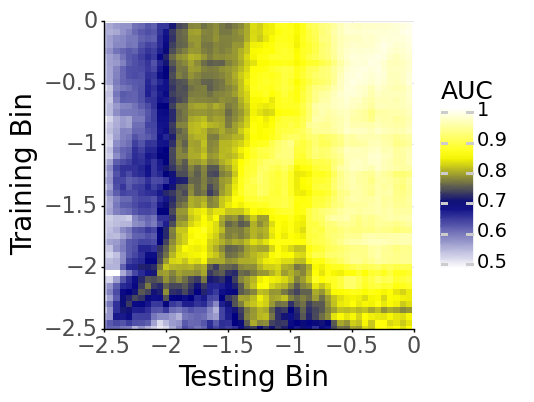

<ggplot: (435044798)>

In [48]:
p = (ggplot(df_tempgen,aes(x='testtime',y='traintime',fill='accs')) +
     geom_raster(interpolate=False)+
#      ggtitle(f"{chan_ROI[channel]} Site ({channel})")+
#      geom_tile(df_p_plus,fill='red')+
#      geom_tile(df_p_minus,fill='#00A2FF')+
#      geom_tile(df_bonf_plus,fill='#a6212c')+
#      geom_tile(df_bonf_minus,fill='#212ca6')+
#      scale_fill_gradient2(name='AUC',
# # #                             high = '#a6212c', # More muted
# # #                           low = '#212ca6',
#                           high = 'yellow', # More vibrant
#                           low = 'navy',
#                           mid = 'teal',
#                           na_value='white',
#                           midpoint=0.6,
#                           limits=(0.3,1)) +
     scale_fill_gradientn(name='AUC',
                          colors = ['white','navy','yellow','white'],
                          values = [0.,0.4,0.7,1],
                          na_value='white',
                          limits=(0.5,1)) +
     scale_x_continuous(name='Testing Bin') +
     scale_y_continuous(name='Training Bin') +
     coord_cartesian(xlim = (-2.5,0), ylim = (-2.5,0),expand=False)+
     theme_bw() +
     theme(figure_size = (4,4),
         axis_line = element_line(colour = "black", 
                      size = 1, linetype = "solid"),
           panel_background = element_blank(),
           axis_text = element_text(size=16),
           axis_ticks_length = 2,
           axis_title = element_text(size=20),
#            plot_title = element_text(size=32,face='bold'),
#            legend_position = (0.8,0.6),
           legend_text = element_text(size=14),
           legend_title = element_text(size=18),
#            panel_grid_major = element_blank(),
#            panel_grid_minor = element_blank(),
#            axis_line = element_line(colour = "black", 
#                       size = 1, linetype = "solid"),
           
        )
    )

# p.save('figures/decoding/simulated_auc_2D_20neurons.svg')
# p.save('figures/decoding/simulated_auc_2D_20neurons.png')

# p.save(savepath+'tfr/LME_'+channel+'_betas.png')


p

## Inspect Covariance Matrix--No Asymmetry

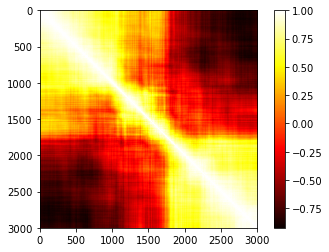

In [16]:
spks_mean = uniform_filter1d(spks,400)

spks_mean = np.mean(spks_mean,axis=0)

plt.plot(time,spks_mean[1,:])

spks_cov = np.corrcoef(spks_mean.T)
plt.imshow(spks_cov, cmap='hot', interpolation='nearest')

plt.colorbar()

plt.show()

# Two conditions that ramp differently

In [50]:
nNeurons = 20
nTrials = 30
time_frs = np.arange(-3,0.001,0.05)
time = np.arange(-3,0.001,0.001)

spksA = np.zeros((nTrials,nNeurons,time.shape[0]))
spksB = np.zeros((nTrials,nNeurons,time.shape[0]))

In [51]:
frs_start = np.zeros(nNeurons,)
frs_end = np.zeros(nNeurons,)

frs_start[0:(frs_start.shape[0]//2)] = 5 #+ np.random.randn(nNeurons//2) # Starting FRs for each increasing neuron
frs_start[(frs_start.shape[0]//2):] = 8 #+ np.random.randn(nNeurons//2) # Starting FRs for each decreasing neuron

frs_end[0:(frs_start.shape[0]//2)] = 8 #+ np.random.randn(nNeurons//2) # Ending FRs for each increasing neuron
frs_end[(frs_start.shape[0]//2):] = 5 #+ np.random.randn(nNeurons//2) # Ending FRs for each decreasing neuron

In [52]:
# Condition A

for ii in range(nNeurons):
    
    if nNeurons < nNeurons//2:
        this_frs = np.linspace(frs_start[ii],frs_end[ii],time_frs.shape[0])
    else:
        this_frs = np.linspace(frs_start[ii],frs_start[ii],time_frs.shape[0])
    
    for kk in range(time_frs.shape[0]-1):
        
        x,y = spksA[:,ii,(kk)*50:(kk+1)*50].shape
        spksA[:,ii,(kk)*50:(kk+1)*50] = np.random.rand(nTrials,50) < this_frs[kk]/1000
        
# Condition B
for ii in range(nNeurons):
    
    if nNeurons >= nNeurons//2:
        this_frs = np.linspace(frs_start[ii],frs_end[ii],time_frs.shape[0])
    else:
        this_frs = np.linspace(frs_start[ii],frs_start[ii],time_frs.shape[0])
    
    for kk in range(time_frs.shape[0]-1):
        
        x,y = spksB[:,ii,(kk)*50:(kk+1)*50].shape
        spksB[:,ii,(kk)*50:(kk+1)*50] = np.random.rand(nTrials,50) < this_frs[kk]/1000
        
        

In [53]:
baseline_ix = np.where(np.logical_and(time > -3,time < -2.6))[0]
baseline_frs = spks[:,:,baseline_ix].sum(axis=2)

df_base = pd.DataFrame(baseline_frs)
df_base['label'] = np.zeros(len(df_base,))

accs = []
# sems = []
traintime = []
testtime = []

for tt_train in time[time > -2.5][::50]:
    for tt_test in time[time > -2.5][::50]:
        
        # Training set for A
        train_ix = np.where(np.logical_and(time > tt_train-0.4,time < tt_train))[0]
        train_frs = spksA[:,:,train_ix].sum(axis=2)

        df_trainA = pd.DataFrame(train_frs)
        df_trainA['label'] = np.ones(len(df_trainA,))
        
        # Training set for B
        train_ix = np.where(np.logical_and(time > tt_train-0.4,time < tt_train))[0]
        train_frs = spksB[:,:,train_ix].sum(axis=2)
        
        df_trainB = pd.DataFrame(train_frs)
        df_trainB['label'] = np.zeros(len(df_trainB,))

        tmp = pd.concat([df_trainA,df_trainB]).dropna()
        X_train = tmp.drop('label',axis=1).to_numpy()
        y_train = tmp['label'].to_numpy().flatten()

        # Training set for A
        test_ix = np.where(np.logical_and(time > tt_test-0.4,time < tt_test))[0]
        test_frs = spksA[:,:,test_ix].sum(axis=2)

        df_testA = pd.DataFrame(test_frs)
        df_testA['label'] = np.ones(len(df_testA,))
        
        # Training set for B
        test_ix = np.where(np.logical_and(time > tt_test-0.4,time < tt_test))[0]
        test_frs = spksB[:,:,test_ix].sum(axis=2)
        
        df_testB = pd.DataFrame(test_frs)
        df_testB['label'] = np.zeros(len(df_testB,))

        tmp = pd.concat([df_testA,df_testB]).dropna()
        X_test = tmp.drop('label',axis=1).to_numpy()
        y_test = tmp['label'].to_numpy().flatten()

        clf = LDA()
#             clf = SVC()

        clf.fit(X_train,y_train)

#         accs_this = clf.score(X_test,y_test)
        accs_this = roc_auc_score(y_test,clf.predict_proba(X_test)[:,1])

        

        accs.append(accs_this)
        traintime.append(tt_train)
        testtime.append(tt_test)
        
        if tt_train == tt_test:
            print(tt_train,accs_this)
        
        
        
df_tempgen = pd.DataFrame({'accs':accs,'traintime':traintime,'testtime':testtime})

-2.499000000000055 0.9355555555555555
-2.4490000000000607 0.9066666666666667
-2.399000000000066 0.8933333333333333
-2.3490000000000717 0.8744444444444445
-2.299000000000077 0.8466666666666667
-2.2490000000000827 0.8311111111111111
-2.199000000000088 0.8377777777777777
-2.1490000000000937 0.8788888888888889
-2.0990000000000992 0.9288888888888889
-2.0490000000001047 0.9433333333333334
-1.9990000000001102 0.9588888888888889
-1.9490000000001158 0.9744444444444444
-1.8990000000001213 0.9866666666666667
-1.8490000000001268 0.9888888888888889
-1.7990000000001323 0.9688888888888889
-1.7490000000001378 0.96
-1.6990000000001433 0.9222222222222222
-1.6490000000001488 0.9255555555555555
-1.5990000000001543 0.8788888888888889
-1.5490000000001598 0.8877777777777778
-1.4990000000001653 0.9488888888888889
-1.4490000000001708 0.9422222222222222
-1.3990000000001763 0.97
-1.3490000000001818 0.9755555555555555
-1.2990000000001873 0.9955555555555555
-1.2490000000001928 0.98
-1.1990000000001984 0.9877777777

In [54]:
print("T-Test output: ",ttest_ind(df_tempgen.loc[df_tempgen.traintime.values > df_tempgen.testtime.values,'accs'],
               df_tempgen.loc[df_tempgen.traintime.values < df_tempgen.testtime.values,'accs']))
print("Rank-Sum output: ",ranksums(df_tempgen.loc[df_tempgen.traintime.values > df_tempgen.testtime.values,'accs'],
               df_tempgen.loc[df_tempgen.traintime.values < df_tempgen.testtime.values,'accs']))

T-Test output:  Ttest_indResult(statistic=-13.121723486333611, pvalue=4.614511984980102e-38)
Rank-Sum output:  RanksumsResult(statistic=-12.494875497887994, pvalue=7.96208386618313e-36)


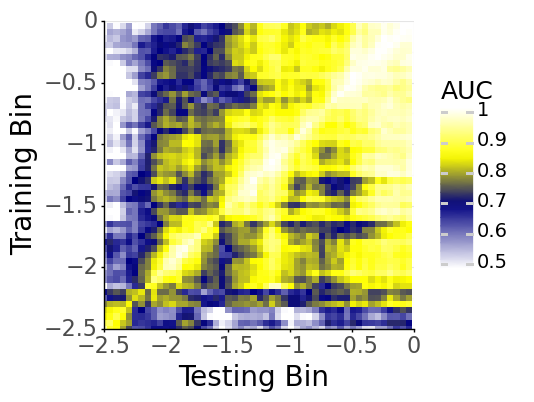

<ggplot: (434816627)>

In [55]:
p = (ggplot(df_tempgen,aes(x='testtime',y='traintime',fill='accs')) +
     geom_raster(interpolate=False)+
#      ggtitle(f"{chan_ROI[channel]} Site ({channel})")+
#      geom_tile(df_p_plus,fill='red')+
#      geom_tile(df_p_minus,fill='#00A2FF')+
#      geom_tile(df_bonf_plus,fill='#a6212c')+
#      geom_tile(df_bonf_minus,fill='#212ca6')+
#      scale_fill_gradient2(name='AUC',
# # #                             high = '#a6212c', # More muted
# # #                           low = '#212ca6',
#                           high = 'yellow', # More vibrant
#                           low = 'navy',
#                           mid = 'teal',
#                           na_value='white',
#                           midpoint=0.6,
#                           limits=(0.3,1)) +
     scale_fill_gradientn(name='AUC',
                          colors = ['white','navy','yellow','white'],
                          values = [0.,0.4,0.7,1],
                          na_value='white',
                          limits=(0.5,1)) +
     scale_x_continuous(name='Testing Bin') +
     scale_y_continuous(name='Training Bin') +
     coord_cartesian(xlim = (-2.5,0), ylim = (-2.5,0),expand=False)+
     theme_bw() +
     theme(figure_size = (4,4),
         axis_line = element_line(colour = "black", 
                      size = 1, linetype = "solid"),
           panel_background = element_blank(),
           axis_text = element_text(size=16),
           axis_ticks_length = 2,
           axis_title = element_text(size=20),
#            plot_title = element_text(size=32,face='bold'),
#            legend_position = (0.8,0.6),
           legend_text = element_text(size=14),
           legend_title = element_text(size=18),
#            panel_grid_major = element_blank(),
#            panel_grid_minor = element_blank(),
#            axis_line = element_line(colour = "black", 
#                       size = 1, linetype = "solid"),
           
        )
    )

# p.save('figures/decoding/simulated_auc_2D.svg')
# p.save('figures/decoding/simulated_auc_2D.png')

# p.save(savepath+'tfr/LME_'+channel+'_betas.png')


p

## Inspect covariance matrix--no asymmetry

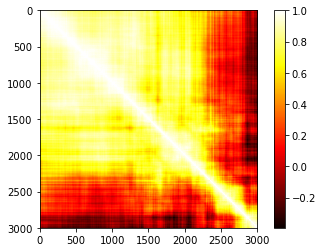

In [282]:
spks_mean = uniform_filter1d(np.concatenate((spksA,spksB)),400)

spks_mean = np.mean(spks_mean,axis=0)

plt.plot(time,spks_mean[1,:])

spks_cov = np.corrcoef(spks_mean.T)
plt.imshow(spks_cov, cmap='hot', interpolation='nearest')

plt.colorbar()

plt.show()